# Results - Classification on simulated events
This notebook is the primary source of plots and tables for the classificationn part of the thesis, 
with the goal of keeping every table and figure as standardized as possible. (And who has the time to update 90 tables one by one anyway).

## Questions
* Descriptive statistics
    - Should descriptive statistics of the simulated data be included?\
    If so, how much? And should it be included for each fold in the k-fold cross-validation?
* Classification results
    - Breakdown of results based on event type? Single, double, close double?
    Reasonable to include in order to confirm the assumption that close doubles are the
    most difficult event type to classify correctly in simulated data
    Random state is included, so should be simple to reproduce the indices


## TODO
* Implement reproducing the validation indices for each fold based on the random seed from config
* Run this for pixelmod data

## Handy links
* [matplotlib-plots to latex](https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/)
* [Robert's thesis df output](https://github.com/ATTPC/VAE-event-classification/blob/master/src/make_classification_table.py)

In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from master_scripts.data_functions import get_git_root
from master_scripts.analysis_functions import load_experiment, experiment_metrics_to_df
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

THESIS_PATH = "../../../master_thesis/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pre-processed simulated data - no additional modifications
This is the basic metrics for all the models trained on simulated data.
The basic pre-processing includes formatting and min-max normalization.

Unmodded custom model 424cc250c5ab \
Pixelmod custom model 60f95ed56212

## Logistic regression

In [18]:
# Load logistic regression experiment
log_ex_id = "003e1b62336e"
log_ex = load_experiment(log_ex_id)
#log_model = tf.keras.models.load_model(repo_root + "models/" + log_ex_id + ".h5")

log_metrics = experiment_metrics_to_df(log_ex)
display(log_metrics)
log_means = log_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
log_means = log_means.rename(index={'mean': 'log_mean', 'std': 'log_std'})
display(log_means)

,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
fold_0,0.740821,0.720636,0.486738,0.832966,154484,35527,62961,127028
fold_1,0.721626,0.736618,0.446164,0.832152,126294,63718,42064,147924
fold_2,0.720718,0.737242,0.444982,0.832358,124988,65024,41103,148885
fold_3,0.709929,0.739569,0.431198,0.833482,113262,76750,33477,156511
fold_4,0.718650,0.737511,0.441900,0.831870,122891,67121,39792,150196


,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
log_mean,0.722349,0.734316,0.450196,0.832565,128383.800000,61628.000000,43879.400000,146108.800000
log_std,0.011317,0.007727,0.021263,0.000652,15459.292099,15459.714179,11180.656255,11180.229591


## Small dense network

In [19]:
# Load logistic regression experiment
dense_ex_id = "c19117f62bd8"
dense_ex = load_experiment(dense_ex_id)
#log_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5")

dense_metrics = experiment_metrics_to_df(dense_ex)
display(dense_metrics)
dense_means = dense_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
dense_means = dense_means.rename(index={'mean': 'dense_mean', 'std': 'dense_std'})
display(dense_means)

,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
fold_0,0.927039,0.921922,0.861499,0.962638,188591,1420,26305,163684
fold_1,0.908492,0.908957,0.817028,0.959432,171644,18368,16405,173583
fold_2,0.909421,0.910222,0.818975,0.960006,171095,18917,15503,174485
fold_3,0.879271,0.885307,0.762790,0.919938,157063,32949,12928,177060
fold_4,0.904984,0.906353,0.810318,0.953581,169170,20842,15264,174724


,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
dense_mean,0.905842,0.906552,0.814122,0.951119,171512.600000,18499.200000,17281.000000,172707.200000
dense_std,0.017146,0.013294,0.035093,0.017742,11248.801238,11249.180801,5205.240965,5204.807556


## Small CNN

In [20]:
# Load logistic regression experiment
cnn_ex_id = "b56e64ac3b1c"
cnn_ex = load_experiment(cnn_ex_id)
#log_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5")

cnn_metrics = experiment_metrics_to_df(cnn_ex)
display(cnn_metrics)
cnn_means = cnn_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
cnn_means = cnn_means.rename(index={'mean': 'cnn_mean', 'std': 'cnn_std'})
display(cnn_means)

,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
fold_0,0.950571,0.948138,0.905124,0.982672,189521,490,18293,171696
fold_1,0.960053,0.958639,0.922254,0.985671,188904,1108,14072,175916
fold_2,0.963263,0.962188,0.928021,0.986537,188422,1590,12370,177618
fold_3,0.961945,0.960966,0.925047,0.987761,187532,2480,11981,178007
fold_4,0.965118,0.964110,0.931703,0.988156,188713,1299,11956,178032


,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
cnn_mean,0.960190,0.958808,0.922430,0.986160,188618.400000,1393.400000,13734.400000,176253.800000
cnn_std,0.005687,0.006286,0.010291,0.002185,728.704535,729.014266,2692.281245,2691.857946


## Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes and issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.

In [21]:
# Load logistic regression experiment
pretrained_ex_id = "c96f61c743c2"
pretrained_ex = load_experiment(pretrained_ex_id)
#log_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5")

pretrained_metrics = experiment_metrics_to_df(pretrained_ex)
display(pretrained_metrics)
pretrained_means = pretrained_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
pretrained_means = pretrained_means.rename(index={'mean': 'pretrained_mean', 'std': 'pretrained_std'})
display(pretrained_means)

,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
fold_0,0.884926,0.870529,0.789605,0.933739,189264,747,42981,147008
fold_1,0.907403,0.902052,0.819700,0.949066,182786,7226,27961,162027
fold_2,0.905205,0.902705,0.811477,0.951145,176872,13140,22882,167106
fold_3,0.882782,0.884662,0.765974,0.944825,164630,25382,19161,170827
fold_4,0.912111,0.909292,0.825810,0.956346,179204,10808,22590,167398


,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
pretrained_mean,0.898485,0.893848,0.802513,0.947024,178551.200000,11460.600000,27115.000000,162873.200000
pretrained_std,0.013609,0.015909,0.024598,0.008505,9079.417448,9079.712429,9408.848256,9408.426686


## Custom model

In [ ]:
# Load custom classification experiment
custom_ex_id = "424cc250c5ab"
custom_ex = load_experiment(custom_ex_id)
#log_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5")

custom_metrics = experiment_metrics_to_df(custom_ex)
display(custom_metrics)
custom_means = custom_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
custom_means = custom_means.rename(index={'mean': 'custom_mean', 'std': 'custom_std'})
display(custom_means)

## Combine the metrics into one table
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [22]:
all_means = pd.DataFrame(
    [
        log_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        dense_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        cnn_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        pretrained_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        custom_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
    ]
).rename(
    index={
        'log_mean': 'Logistic',
        'dense_mean': 'Dense',
        'cnn_mean': 'Convolutional',
        'pretrained_mean': 'Pretrained VGG16',
    }
)
display(all_means)
all_std = pd.DataFrame(
    [
        log_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        dense_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        cnn_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        pretrained_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        custom_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
    ]
).rename(
    index={
        'log_std': 'Logistic',
        'dense_std': 'Dense',
        'cnn_std': 'Convolutional',
        'pretrained_std': 'Pretrained VGG16',
        'custom_std': 'Custom'
    }
)
display(all_std)

,f1_score,roc_auc_score,TN,FP,FN,TP
Logistic,0.734316,0.832565,128383.8,61628.0,43879.4,146108.8
Dense,0.906552,0.951119,171512.6,18499.2,17281.0,172707.2
Convolutional,0.958808,0.986160,188618.4,1393.4,13734.4,176253.8
Pretrained VGG16,0.893848,0.947024,178551.2,11460.6,27115.0,162873.2


,f1_score,roc_auc_score,TN,FP,FN,TP
Logistic,0.007727,0.000652,15459.292099,15459.714179,11180.656255,11180.229591
Dense,0.013294,0.017742,11248.801238,11249.180801,5205.240965,5204.807556
Convolutional,0.006286,0.002185,728.704535,729.014266,2692.281245,2691.857946
Pretrained VGG16,0.015909,0.008505,9079.417448,9079.712429,9408.848256,9408.426686


### Output combined frames to latex
Make one table for f1-scores, one for roc auc scores.

In [23]:
rows = all_means.index
f1_auc_str_array = np.zeros((2, all_means.shape[0]), dtype=object)
#auc_str_array = np.zeros((1, all_means.shape[0]), dtype=object)
for i in range(all_means.shape[0]):
    f1_auc_str_array[0, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
        all_std["f1_score"][i], all_means["f1_score"][i])
    f1_auc_str_array[1, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
        all_std['roc_auc_score'][i], all_means['roc_auc_score'][i])
        
#f1_df = pd.DataFrame(f1_str_array, columns=rows)
#auc_df = pd.DataFrame(auc_str_array, columns=rows)
f1_auc_df = pd.DataFrame(f1_auc_str_array, columns=rows, index=['F1-score', 'AUC'])

section_path = "chapters/results/figures/"
fname = THESIS_PATH + section_path + "classification_simulated_f1_auc.tex"
caption = """
Mean F1-scores and roc-auc scores for classification of simulated data using multiple models. 
Error estimates are the standard deviation in results from k-fold cross-validation 
with $K=5$ folds.
"""
label = "tab:classification-simulated-f1-auc"
with open(fname, "w") as fp:
    pd.set_option('display.max_colwidth', -1)
    f1_auc_df.to_latex(fp, escape=False, caption=caption, label=label, index=True)


# Pre-processed simulated data - Pixel modified
The basic pre-processing includes formatting and min-max normalization.
Additionally, the data has had the top and bottom lines of pixels set to 0, plus
one pixel inside the detector permanently 0 (which idx again?).

## Logistic regression

In [26]:
# Load logistic regression experiment
log_ex_id = "b89547da983e"
log_ex = load_experiment(log_ex_id)
#log_model = tf.keras.models.load_model(repo_root + "models/" + log_ex_id + ".h5")

log_metrics = experiment_metrics_to_df(log_ex)
display(log_metrics)
log_means = log_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
log_means = log_means.rename(index={'mean': 'log_mean', 'std': 'log_std'})
display(log_means)

,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
fold_0,0.735916,0.731402,0.472092,0.833491,143017,47007,53345,136631
fold_1,0.721734,0.737591,0.446453,0.831449,125648,64035,41706,148611
fold_2,0.723992,0.734346,0.449483,0.830934,130153,60064,44819,144964
fold_3,0.723684,0.735852,0.449721,0.831982,128748,61857,43143,146252
fold_4,0.731503,0.734669,0.463060,0.832420,136718,52812,49217,141253


,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
log_mean,0.727366,0.734772,0.456162,0.832055,132856.800000,57155.000000,46446.00000,143542.200000
log_std,0.006059,0.002273,0.010974,0.000978,6969.542646,7066.629996,4777.53022,4692.078079


## Small dense network

In [27]:
# Load logistic regression experiment
dense_ex_id = "bc4937925065"
dense_ex = load_experiment(dense_ex_id)
#log_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5")

dense_metrics = experiment_metrics_to_df(dense_ex)
display(dense_metrics)
dense_means = dense_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
dense_means = dense_means.rename(index={'mean': 'dense_mean', 'std': 'dense_std'})
display(dense_means)

,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
fold_0,0.914961,0.908123,0.839234,0.954409,187982,2042,30273,159703
fold_1,0.896450,0.894949,0.793315,0.949147,173041,16642,22707,167610
fold_2,0.905058,0.902114,0.811463,0.951979,177676,12541,23537,166246
fold_3,0.899276,0.897575,0.798822,0.950332,174019,16586,21689,167706
fold_4,0.919671,0.915438,0.844051,0.955263,184248,5282,25243,165227


,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
dense_mean,0.907083,0.903640,0.817377,0.952226,179393.200000,10618.600000,24689.800000,165298.400000
dense_std,0.009983,0.008276,0.023171,0.002604,6509.950361,6663.786446,3381.693245,3292.095731


## Small CNN

In [28]:
# Load logistic regression experiment
cnn_ex_id = "2b135384dd50"
cnn_ex = load_experiment(cnn_ex_id)
#log_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5")

cnn_metrics = experiment_metrics_to_df(cnn_ex)
display(cnn_metrics)
cnn_means = cnn_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
cnn_means = cnn_means.rename(index={'mean': 'cnn_mean', 'std': 'cnn_std'})
display(cnn_means)

,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
fold_0,0.890424,0.877004,0.800079,0.962810,189911,113,41526,148450
fold_1,0.954279,0.953273,0.909544,0.981723,185404,4279,13095,177222
fold_2,0.958521,0.957098,0.918924,0.985011,188423,1794,13968,175815
fold_3,0.960805,0.960004,0.922125,0.985730,186359,4246,10648,178747
fold_4,0.962632,0.961884,0.926175,0.985629,186627,2903,11297,179173


,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
cnn_mean,0.945332,0.941852,0.895369,0.980181,187344.800000,2667.000000,18106.800000,171881.400000
cnn_std,0.030853,0.036397,0.053621,0.009848,1802.889403,1762.989365,13159.728405,13165.576489


## Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes and issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.

In [29]:
# Load logistic regression experiment
pretrained_ex_id = "6bc44ed76ea7"
pretrained_ex = load_experiment(pretrained_ex_id)
#log_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5")

pretrained_metrics = experiment_metrics_to_df(pretrained_ex)
display(pretrained_metrics)
pretrained_means = pretrained_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
pretrained_means = pretrained_means.rename(index={'mean': 'pretrained_mean', 'std': 'pretrained_std'})
display(pretrained_means)

,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
fold_0,0.889703,0.876505,0.797791,0.937721,189348,676,41237,148739
fold_1,0.910158,0.905095,0.825357,0.950728,183065,6618,27522,162795
fold_2,0.921355,0.917173,0.846828,0.957505,184651,5566,24319,165464
fold_3,0.918887,0.916617,0.838717,0.959171,179761,10844,19979,169416
fold_4,0.929674,0.926033,0.864011,0.961164,185991,3539,23185,167285


,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
pretrained_mean,0.913955,0.908285,0.834541,0.953258,184563.200000,5448.600000,27248.400000,162739.800000
pretrained_std,0.015238,0.019258,0.024859,0.009530,3544.233373,3772.131466,8271.828202,8195.687933


## Custom model

In [ ]:
# Load custom classification experiment
custom_ex_id = "60f95ed56212"
custom_ex = load_experiment(custom_ex_id)
#log_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5")

custom_metrics = experiment_metrics_to_df(custom_ex)
display(custom_metrics)
custom_means = custom_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
custom_means = custom_means.rename(index={'mean': 'custom_mean', 'std': 'custom_std'})
display(custom_means)

## Combine the metrics into one table
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [30]:
all_means_pmod = pd.DataFrame(
    [
        log_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        dense_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        cnn_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        pretrained_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        custom_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
    ]
).rename(
    index={
        'log_mean': 'Logistic',
        'dense_mean': 'Dense',
        'cnn_mean': 'Convolutional',
        'pretrained_mean': 'Pretrained VGG16',
        'custom_mean': 'Custom',
    }
)
display(all_means_pmod)
all_std_pmod = pd.DataFrame(
    [
        log_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        dense_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        cnn_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        pretrained_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        custom_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
    ]
).rename(
    index={
        'log_std': 'Logistic',
        'dense_std': 'Dense',
        'cnn_std': 'Convolutional',
        'pretrained_std': 'Pretrained VGG16',
        'custom_std': 'Custom',
    }
)
display(all_std_pmod)

,f1_score,roc_auc_score,TN,FP,FN,TP
Logistic,0.734772,0.832055,132856.8,57155.0,46446.0,143542.2
Dense,0.903640,0.952226,179393.2,10618.6,24689.8,165298.4
Convolutional,0.941852,0.980181,187344.8,2667.0,18106.8,171881.4
Pretrained VGG16,0.908285,0.953258,184563.2,5448.6,27248.4,162739.8


,f1_score,roc_auc_score,TN,FP,FN,TP
Logistic,0.002273,0.000978,6969.542646,7066.629996,4777.530220,4692.078079
Dense,0.008276,0.002604,6509.950361,6663.786446,3381.693245,3292.095731
Convolutional,0.036397,0.009848,1802.889403,1762.989365,13159.728405,13165.576489
Pretrained VGG16,0.019258,0.009530,3544.233373,3772.131466,8271.828202,8195.687933


### Output combined frame to latex

In [31]:
rows = all_means_pmod.index
f1_auc_str_array = np.zeros((2, all_means_pmod.shape[0]), dtype=object)
#auc_str_array = np.zeros((1, all_means.shape[0]), dtype=object)
for i in range(all_means_pmod.shape[0]):
    f1_auc_str_array[0, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
        all_std_pmod["f1_score"][i], all_means_pmod["f1_score"][i])
    f1_auc_str_array[1, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
        all_std_pmod['roc_auc_score'][i], all_means_pmod['roc_auc_score'][i])
        
#f1_df = pd.DataFrame(f1_str_array, columns=rows)
#auc_df = pd.DataFrame(auc_str_array, columns=rows)
f1_auc_df = pd.DataFrame(f1_auc_str_array, columns=rows, index=['F1-score', 'AUC'])

section_path = "chapters/results/figures/"
fname = THESIS_PATH + section_path + "classification_simulated_pixelmod_f1_auc.tex"
caption = """
Mean F1-scores and roc-auc scores for classification of simulated data with specific pixels
modified, using multiple models. Error estimates are the standard deviation in results from 
k-fold cross-validation with $K=5$ folds.
"""
label = "tab:classification-simulated-pixelmod-f1-auc"
with open(fname, "w") as fp:
    pd.set_option('display.max_colwidth', -1)
    f1_auc_df.to_latex(fp, escape=False, caption=caption, label=label, index=True)


# Pre-processed simulated data - Pixel modified and imbalanced
The basic pre-processing includes formatting and min-max normalization.
Additionally, the data has had the top and bottom lines of pixels set to 0, plus
one pixel inside the detector permanently 0 (which idx again?).

This dataset has also been purposefully imbalanced to mimic the properties of experimental data
where doubles in space are expected to be rare.

# Confusion matrix for all the sets

### Plot confusion matrix for both data variants in one grid

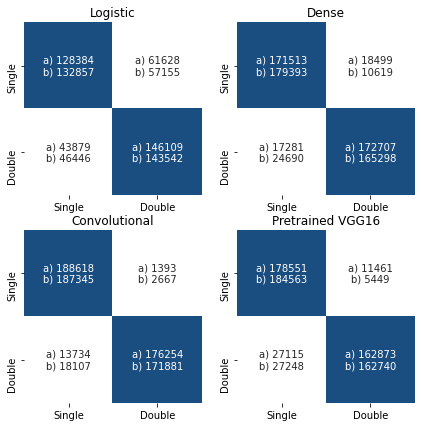

In [55]:
tlabs = ['Single', 'Double']
cm_log = all_means.loc['Logistic'][2:].values
cm_dense = all_means.loc['Dense'][2:].values
cm_cnn = all_means.loc['Convolutional'][2:].values
cm_pretrained = all_means.loc['Pretrained VGG16'][2:].values
cm_custom = all_means.loc['Custom'][2:].values

cm_log_pmod = all_means_pmod.loc['Logistic'][2:].values
cm_dense_pmod = all_means_pmod.loc['Dense'][2:].values
cm_cnn_pmod = all_means_pmod.loc['Convolutional'][2:].values
cm_pretrained_pmod = all_means_pmod.loc['Pretrained VGG16'][2:].values
cm_custom_pmod = all_means_pmod.loc['Custom'][2:].values

cm_log_tot = np.array(["a) {:.0f}\nb) {:.0f}".format(a,b) for a,b in zip(cm_log, cm_log_pmod)]).reshape(2,2)
cm_dense_tot = np.array(["a) {:.0f}\nb) {:.0f}".format(a,b) for a,b in zip(cm_dense, cm_dense_pmod)]).reshape(2,2)
cm_cnn_tot = np.array(["a) {:.0f}\nb) {:.0f}".format(a,b) for a,b in zip(cm_cnn, cm_cnn_pmod)]).reshape(2,2)
cm_pretrained_tot = np.array(["a) {:.0f}\nb) {:.0f}".format(a,b) for a,b in zip(cm_pretrained, cm_pretrained_pmod)]).reshape(2,2)
cm_custom_tot = np.array(["a) {:.0f}\nb) {:.0f}".format(a,b) for a,b in zip(cm_custom, cm_custom_pmod)]).reshape(2,2)

cmap = matplotlib.colors.ListedColormap([(1.0, 1.0, 1.0), (0.1, 0.3, 0.5)])

fig1 = plt.figure()
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig1)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig1)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig1)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2, fig=fig1)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2, fig=fig1)
sns.heatmap(cm_log.reshape(2,2), annot=cm_log_tot, cmap=cmap, fmt='', xticklabels=tlabs, yticklabels=tlabs, cbar=False, ax=ax1)
ax1.set_title("Logistic")
sns.heatmap(cm_dense.reshape(2,2), annot=cm_dense_tot, cmap=cmap, fmt='', xticklabels=tlabs, yticklabels=tlabs, cbar=False, ax=ax2)
ax2.set_title("Dense")
sns.heatmap(cm_cnn.reshape(2,2), annot=cm_cnn_tot, cmap=cmap, fmt='', xticklabels=tlabs, yticklabels=tlabs, cbar=False, ax=ax3)
ax3.set_title("Convolutional")
sns.heatmap(cm_pretrained.reshape(2,2), annot=cm_pretrained_tot, cmap=cmap, fmt='', xticklabels=tlabs, yticklabels=tlabs, cbar=False, ax=ax4)
ax4.set_title("Pretrained VGG16")
sns.heatmap(cm_custom.reshape(2,2), annot=cm_custom_tot, cmap=cmap, fmt='', xticklabels=tlabs, yticklabels=tlabs, cbar=False, ax=ax5)
ax5.set_title("Custom")
#plt.savefig(THESIS_PATH + section_path + 'confmat_simulated.pdf')

# Classifying experimental data and comparing with simulated data